In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
RANDOM_STATE = 6

In [3]:
home = Path.cwd().parent
data_dir = home / "data"
notebook_dir = home / "notebooks"
df = pd.read_csv(data_dir / "processed" / "german_credit.csv")

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["class"]),
    df["class"],
    test_size=0.3,
    random_state=RANDOM_STATE
)

X_train.shape, y_train.shape

((700, 20), (700,))

### Create a copy of the datset

In [5]:
train_df = X_train.copy()
train_df["target"] = y_train
train_df.shape


(700, 21)

### Drop unecessary features

In [6]:
cols_to_drop = [
    "other_debtors_guarantors",
    "job",
    "telephone",
    "foreign_worker",
    "present_residence_since",
    "existing_credits_count",
    "people_liable_for_maintenance",
    #"installment_rate_pct_of_disp_income"
]

In [7]:
train_df.drop(columns=cols_to_drop, inplace=True)
train_df.shape

(700, 14)

### Basic transformations - Onehot & Standardization

In [67]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Automatically select categorical columns

train_df.drop(columns=["target"], inplace=True)
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

encoder = OneHotEncoder(
    categories="auto",
    drop="first",  # to return k-1, use drop=false to return k dummies
    sparse_output=False,
    handle_unknown="error",  # helps deal with rare labels
)


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ])

preprocessor.set_output(transform="pandas")

preprocessor.fit(train_df)



,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,'first'
,sparse_output,False


In [68]:
train_enc_1 = preprocessor.transform(train_df)
train_enc_1.sample(1, random_state=RANDOM_STATE).T

,637
cat__checking_account_status_< 0 DM,0.000000
cat__checking_account_status_>= 200 DM / salary assign.,0.000000
cat__checking_account_status_no checking account,1.000000
cat__credit_history_critical/other credits exist,0.000000
cat__credit_history_delay in paying off in past,1.000000
cat__credit_history_existing credits paid duly,0.000000
cat__credit_history_no credits/all paid duly,0.000000
cat__purpose_car (new),0.000000
cat__purpose_car (used),0.000000
cat__purpose_domestic appliances,0.000000


In [45]:
train_df.sample(1, random_state=RANDOM_STATE).T

,637
checking_account_status,no checking account
duration_months,60
credit_history,delay in paying off in past
purpose,radio/television
credit_amount,15653
savings_account_bonds,< 100 DM
present_employment_since,4 <= ... < 7 years
installment_rate_pct_of_disp_income,2
personal_status_sex,male: single
property,car or other


In [46]:
train_enc_1.shape

(700, 39)

### First baseline

In [116]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


base_dummy = DummyClassifier(strategy="most_frequent")
base_svc = LinearSVC()
base_svc_rbf = SVC(kernel="rbf")
base_rf = RandomForestClassifier()

base_dummy.fit(X_train, y_train)
base_svc.fit(train_enc_1, y_train)
base_svc_rbf.fit(train_enc_1, y_train)
base_rf.fit(train_enc_1, y_train)   

score_1 = cross_val_score(base_dummy, train_df, y_train, cv=5, scoring="roc_auc").mean()
score_2 = cross_val_score(base_svc, train_enc_1, y_train, cv=5, scoring="roc_auc").mean()
score_3 = cross_val_score(base_svc_rbf, train_enc_1, y_train, cv=5, scoring="roc_auc").mean()
score_4 = cross_val_score(base_rf, train_enc_1, y_train, cv=5, scoring="roc_auc").mean()   

print(f"Dummy score : {score_1}", "\n", f"Linear SVM score : {score_2}", "\n", f"RBF SVM score : {score_3}", "\n", f"Random Forest score : {score_4}")

Dummy score : 0.5 
 Linear SVM score : 0.7670929931454683 
 RBF SVM score : 0.7541501904036558 
 Random Forest score : 0.7737428281289669


### Detailed enginnering feture by feature

1 - checking account status - Weight of evidence encoding

In [8]:
def calculate_woe(df, cat_var, target_var):
    """
    Calculate Weight of Evidence for credit risk modeling.
    WoE = ln(% of goods / % of bads)
    """
    # Create contingency table
    grouped = df.groupby(cat_var)[target_var].agg([
        ('n_obs', 'count'),
        ('n_good', lambda x: (x == 1).sum()),
        ('n_bad', lambda x: (x == 2).sum())
    ]).reset_index()
    
    df_woe = grouped
    
    # Calculate distributions
    df_woe['pct_good'] = df_woe['n_good'] / df_woe['n_good'].sum()
    df_woe['pct_bad'] = df_woe['n_bad'] / df_woe['n_bad'].sum()
    
    # Calculate WoE (with smoothing to avoid log(0))
    df_woe['woe'] = np.log((df_woe['pct_good'] + 0.5) / (df_woe['pct_bad'] + 0.5))
    
    # Create mapping dictionary
    woe_map = dict(zip(df_woe[cat_var], df_woe['woe']))
    
    return woe_map, df_woe



In [9]:
# Apply WoE encoding
woe_map, woe_table = calculate_woe(train_df, 'checking_account_status', 'target')
checking_feature = train_df['checking_account_status'].map(woe_map)

print("\nWoE Table:")
print(woe_table[['checking_account_status', 'n_obs', 'pct_good', 'pct_bad', 'woe']])


WoE Table:
      checking_account_status  n_obs  pct_good   pct_bad       woe
0           0 <= ... < 200 DM    189  0.238569  0.350254 -0.140821
1                      < 0 DM    190  0.196819  0.461929 -0.322415
2  >= 200 DM / salary assign.     43  0.067594  0.045685  0.039365
3         no checking account    278  0.497018  0.142132  0.439975


In [11]:
checking_feature.unique()

array([ 0.43997486, -0.14082093, -0.32241476,  0.03936474])

2 - credit history - merge 'all credits here paid duly' with 'no credits/all paid duly', and 'critical/other credits exist' with 'delay in paying off in past' (+critical account flag) and use ordinal encoding. Report your choice for data vs theory discrepancy

In [12]:
train_df["credit_history"].unique()

array(['existing credits paid duly', 'no credits/all paid duly',
       'critical/other credits exist', 'delay in paying off in past',
       'all credits here paid duly'], dtype=object)

In [13]:
train_df["critical_acc_flag"] = train_df["credit_history"].apply(lambda x: 1 if x == "critical/other credits exist" else 0)

credit_order = {
    'no credits/all paid duly' : 1,
    'all credits here paid duly' : 1,
    'existing credits paid duly' : 2,
    'delay in paying off in past' : 3,
    'critical/other credits exist' : 3
}

credit_history_feature = train_df["credit_history"].map(credit_order)

3 - Purpose - merge domestic appliances with repairs and others, retraining with education

In [54]:
train_df["purpose"].unique()

array(['car (new)', 'radio/television', 'furniture/equipment', 'repairs',
       'car (used)', 'domestic appliances', 'business', 'education',
       'others', 'retraining'], dtype=object)

In [14]:
purpose_map = {
    'car (new)' : "cat1",
    'car (used)' : "cat2",
    'furniture/equipment' : "cat3",
    'radio/television' : "cat4",
    'education' : "cat5",
    'retraining' : "cat5",
    'domestic appliances' : "cat6",
    'repairs' : "cat6",
    'others' : "cat6",
    'business' : "cat7"
}

train_df["purpose_merged"] = train_df["purpose"].map(purpose_map)

In [15]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(
    categories="auto",
    drop="first",  # to return k-1, use drop=false to return k dummies
    sparse_output=False,
    handle_unknown="error",  # helps deal with rare labels
)

encoder.set_output(transform="pandas")

encoder.fit(train_df[["purpose_merged"]])

,categories,'auto'
,drop,'first'
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [16]:
encoder.categories_

[array(['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7'],
       dtype=object)]

In [17]:
purpose_feature = encoder.transform(train_df[["purpose_merged"]])

4 - savings account bonds - merge < 500 with < 500, and >500 with >1000

In [76]:
train_df["savings_account_bonds"].unique()

array(['unknown/no savings account', '< 100 DM', '>= 1000 DM',
       '100 <= ... < 500 DM', '500 <= ... < 1000 DM'], dtype=object)

In [18]:
saving_map = {
    'unknown/no savings account' : 'no',
    '< 100 DM' : '<= 500',
    '100 <= ... < 500 DM' : '<= 500',
    '500 <= ... < 1000 DM' : '> 500',
    '>= 1000 DM' : '> 500'
    }

train_df["savings_map"] = train_df["savings_account_bonds"].map(saving_map)

woe_map, woe_table = calculate_woe(train_df, 'savings_map', 'target')
savings_feature = train_df['savings_map'].map(woe_map)

print("\nWoE Table:")
print(woe_table[['savings_map', 'n_obs', 'pct_good', 'pct_bad', 'woe']])


WoE Table:
  savings_map  n_obs  pct_good   pct_bad       woe
0      <= 500    496  0.654076  0.847716 -0.155111
1       > 500     76  0.131213  0.050761  0.136341
2          no    128  0.214712  0.101523  0.172415


In [20]:
savings_feature.unique()

array([ 0.17241478, -0.15511148,  0.1363412 ])

5 - present employment since - woe

In [112]:
train_df["present_employment_since"].unique()

array(['< 1 year', '4 <= ... < 7 years', '1 <= ... < 4 years',
       '>= 7 years', 'unemployed'], dtype=object)

In [21]:
woe_map, woe_table = calculate_woe(train_df, 'present_employment_since', 'target')
employment_feature = train_df['present_employment_since'].map(woe_map)

print("\nWoE Table:")
print(woe_table[['present_employment_since', 'n_obs', 'pct_good', 'pct_bad', 'woe']])


WoE Table:
  present_employment_since  n_obs  pct_good   pct_bad       woe
0       1 <= ... < 4 years    237  0.337972  0.340102 -0.002538
1       4 <= ... < 7 years    117  0.186879  0.116751  0.107692
2                 < 1 year    121  0.149105  0.233503 -0.122236
3               >= 7 years    179  0.272366  0.213198  0.079699
4               unemployed     46  0.053678  0.096447 -0.074407


6 - personal status sex - merge all males together, keep both original and new, see what works better or even drop

In [81]:
train_df["personal_status_sex"].unique()

array(['male: single', 'female: div/sep/married', 'male: married/widowed',
       'male: divorced/separated'], dtype=object)

encode categories as is

In [23]:
encoder.fit(train_df[["personal_status_sex"]])
encoder.categories_

[array(['female: div/sep/married', 'male: divorced/separated',
        'male: married/widowed', 'male: single'], dtype=object)]

In [24]:
sex_original_feature = encoder.transform(train_df[["personal_status_sex"]])
sex_original_feature

,personal_status_sex_male: divorced/separated,personal_status_sex_male: married/widowed,personal_status_sex_male: single
514,0.0,0.0,1.0
809,0.0,0.0,0.0
241,0.0,0.0,1.0
434,0.0,0.0,1.0
351,0.0,0.0,0.0
...,...,...,...
618,0.0,0.0,0.0
980,0.0,0.0,1.0
227,0.0,0.0,1.0
713,0.0,0.0,1.0


merge males and then encode

In [25]:
sex_map = {
    'male: single': 'male', 
    'female: div/sep/married': 'female', 
    'male: married/widowed': 'male',
    'male: divorced/separated': 'male'
}
train_df["sex_map"] = train_df["personal_status_sex"].map(sex_map)

pd.concat([train_df["sex_map"], train_df["personal_status_sex"]], axis=1).head(20)

,sex_map,personal_status_sex
514,male,male: single
809,female,female: div/sep/married
241,male,male: single
434,male,male: single
351,female,female: div/sep/married
571,male,male: single
520,male,male: single
280,male,male: single
593,female,female: div/sep/married
163,male,male: single


In [26]:
encoder.fit(train_df[["sex_map"]])
encoder.categories_

[array(['female', 'male'], dtype=object)]

In [27]:
sex_merged_feature = encoder.transform(train_df[["sex_map"]])

7 - property - one hot

In [114]:
train_df["property"].unique()

array(['bldg society/life ins.', 'real estate', 'car or other',
       'unknown/no property'], dtype=object)

In [28]:
property_feature = encoder.fit_transform(train_df[["property"]])
property_feature.head()

,property_car or other,property_real estate,property_unknown/no property
514,0.0,0.0,0.0
809,0.0,1.0,0.0
241,0.0,0.0,0.0
434,0.0,1.0,0.0
351,1.0,0.0,0.0


8 - other installments plans - woe

In [117]:
train_df["other_installment_plans"].unique()

array(['none', 'bank', 'stores'], dtype=object)

In [29]:
woe_map, woe_table = calculate_woe(train_df, 'other_installment_plans', 'target')
other_installment_feature = train_df['other_installment_plans'].map(woe_map)

print("\nWoE Table:")
print(woe_table[['other_installment_plans', 'n_obs', 'pct_good', 'pct_bad', 'woe']])


WoE Table:
  other_installment_plans  n_obs  pct_good   pct_bad       woe
0                    bank    106  0.129225  0.208122 -0.118128
1                    none    556  0.827038  0.710660  0.091784
2                  stores     38  0.043738  0.081218 -0.066660


9 - housing - one hot

In [119]:
train_df['housing'].unique()

array(['own', 'rent', 'for free'], dtype=object)

In [30]:
housing_feature = encoder.fit_transform(train_df[["housing"]])
housing_feature.head()

,housing_own,housing_rent
514,1.0,0.0
809,0.0,1.0
241,1.0,0.0
434,1.0,0.0
351,1.0,0.0


10 - duration months + credit ammount - square of duration, quintile binning(check later) and monthly burden (combination of both)

In [31]:
duration_squared_feature = train_df["duration_months"] ** 2
monthly_burden_feature = train_df["credit_amount"] / train_df["duration_months"]

11 - installment rate pct - keep as is, or try pct x amount

In [124]:
train_df["installment_rate_pct_of_disp_income"].unique()

array([4, 2, 3, 1])

In [32]:
pct_x_amount_feature = train_df["installment_rate_pct_of_disp_income"] * train_df["credit_amount"]

12 - age years - bin into age group, then woe

In [33]:
# Create age bins for visualization
train_df['age_group'] = pd.cut(train_df['age_years'],
                          bins=[0, 25, 35, 50, 65, 100],
                          labels=['Young', 'Early_Career', 'Prime', 'Mature', 'Senior'])

# Bad credit rate by age group
age_risk = train_df.groupby('age_group')['target'].apply(
    lambda x: (x==2).mean() * 100
)
print("\nBad Credit Rate by Age Group:")
print(age_risk)

# Expected: U-shaped (high young, low middle, moderate old)


Bad Credit Rate by Age Group:
age_group
Young           37.142857
Early_Career    28.676471
Prime           22.439024
Mature          23.943662
Senior          33.333333
Name: target, dtype: float64


/tmp/ipykernel_9671/1857986753.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_risk = train_df.groupby('age_group')['target'].apply(


In [34]:
woe_map, woe_table = calculate_woe(train_df, 'age_group', 'target')
age_group_feature = train_df['age_group'].map(woe_map)

print("\nWoE Table:")
print(woe_table[['age_group', 'n_obs', 'pct_good', 'pct_bad', 'woe']])


WoE Table:
      age_group  n_obs  pct_good   pct_bad       woe
0         Young    140  0.174950  0.263959 -0.123876
1  Early_Career    272  0.385686  0.395939 -0.011510
2         Prime    205  0.316103  0.233503  0.106710
3        Mature     71  0.107356  0.086294  0.035293
4        Senior     12  0.015905  0.020305 -0.008493


/tmp/ipykernel_9671/764078556.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(cat_var)[target_var].agg([


### Base models on engineered dataset

Scale for SVM

In [89]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
duration_squared_feature_scaled = scaler.fit_transform(duration_squared_feature.values.reshape(-1, 1)).reshape(-1, )
monthly_burden_feature_scaled = scaler.fit_transform(monthly_burden_feature.values.reshape(-1, 1)).reshape(-1, )
pct_x_amount_feature_scaled = scaler.fit_transform(pct_x_amount_feature.values.reshape(-1, 1)).reshape(-1, )
duration_feature = scaler.fit_transform(train_df["duration_months"].values.reshape(-1, 1)).reshape(-1, )
credit_amount_feature = scaler.fit_transform(train_df["credit_amount"].values.reshape(-1, 1)).reshape(-1, )
age_feature = scaler.fit_transform(train_df["age_years"].values.reshape(-1, 1)).reshape(-1, )

duration_squared_feature_scaled = pd.Series(duration_squared_feature_scaled, name="duration_squared", index=train_df.index)
monthly_burden_feature_scaled = pd.Series(monthly_burden_feature_scaled, name="monthly_burden", index=train_df.index)
pct_x_amount_feature_scaled = pd.Series(pct_x_amount_feature_scaled, name="pct_x_amount", index=train_df.index)
duration_feature = pd.Series(duration_feature, name="duration", index=train_df.index)
credit_amount_feature = pd.Series(credit_amount_feature, name="credit_amount", index=train_df.index)
age_feature = pd.Series(age_feature, name="age", index=train_df.index)

In [55]:
pct_x_amount_feature_scaled

0      0.042018
1     -0.669637
2     -0.509567
3     -0.298180
4     -1.007882
         ...   
695   -0.236444
696    1.051673
697    2.964702
698   -0.539914
699   -0.152567
Name: pct_x_amount, Length: 700, dtype: float64

Create the full enginnered dataset

In [118]:
engineered_cols =[
    checking_feature,
    credit_history_feature,
    purpose_feature,
    savings_feature,
    employment_feature,
    sex_merged_feature, #dont use for svm, use for trees
    #sex_original_feature,
    property_feature,
    other_installment_feature,
    housing_feature,
    #duration_feature,
    duration_squared_feature_scaled,
    #credit_amount_feature,
    monthly_burden_feature_scaled,
    pct_x_amount_feature_scaled,
    age_group_feature,
    #age_feature
]

In [63]:
for feat in engineered_cols:
    print(feat.head().index)

Index([514, 809, 241, 434, 351], dtype='int64')
Index([514, 809, 241, 434, 351], dtype='int64')
Index([514, 809, 241, 434, 351], dtype='int64')
Index([514, 809, 241, 434, 351], dtype='int64')
Index([514, 809, 241, 434, 351], dtype='int64')
Index([514, 809, 241, 434, 351], dtype='int64')
Index([514, 809, 241, 434, 351], dtype='int64')
Index([514, 809, 241, 434, 351], dtype='int64')
Index([514, 809, 241, 434, 351], dtype='int64')
Index([514, 809, 241, 434, 351], dtype='int64')
Index([514, 809, 241, 434, 351], dtype='int64')
Index([514, 809, 241, 434, 351], dtype='int64')
Index([514, 809, 241, 434, 351], dtype='int64')


In [119]:
engineered_train_df = pd.concat(engineered_cols, axis=1)
engineered_train_df.shape

(700, 21)

### Second baseline

In [120]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


base_dummy = DummyClassifier(strategy="most_frequent")
base_svc = LinearSVC()
base_svc_rbf = SVC(kernel="rbf")
base_rf = RandomForestClassifier()

base_dummy.fit(engineered_train_df, y_train)
base_svc.fit(engineered_train_df, y_train)
base_svc_rbf.fit(engineered_train_df, y_train)
base_rf.fit(engineered_train_df, y_train)

score_1 = cross_val_score(base_dummy, engineered_train_df, y_train, cv=5, scoring="roc_auc").mean()
score_2 = cross_val_score(base_svc, engineered_train_df, y_train, cv=5, scoring="roc_auc").mean()
score_3 = cross_val_score(base_svc_rbf, engineered_train_df, y_train, cv=5, scoring="roc_auc").mean()
score_4 = cross_val_score(base_rf, engineered_train_df, y_train, cv=5, scoring="roc_auc").mean()

print(f"Dummy score : {score_1}", "\n", f"Linear SVM score : {score_2}", "\n", f"RBF SVM score : {score_3}", "\n", f"Random Forest score : {score_4}")

Dummy score : 0.5 
 Linear SVM score : 0.7855315943132775 
 RBF SVM score : 0.7626376872302615 
 Random Forest score : 0.7827362972835745


In [111]:

base_svc = LinearSVC()
base_svc_rbf = SVC(kernel="rbf")
base_rf = RandomForestClassifier()

base_svc.fit(engineered_train_df, y_train)
base_svc_rbf.fit(engineered_train_df, y_train)
base_rf.fit(engineered_train_df, y_train)

score_2 = cross_val_score(base_svc, engineered_train_df, y_train, cv=5, scoring="accuracy").mean()
score_3 = cross_val_score(base_svc_rbf, engineered_train_df, y_train, cv=5, scoring="accuracy").mean()
score_4 = cross_val_score(base_rf, engineered_train_df, y_train, cv=5, scoring="accuracy").mean()

print(f"Linear SVM score : {score_2}", "\n", f"RBF SVM score : {score_3}", "\n", f"Random Forest score : {score_4}")

Linear SVM score : 0.75 
 RBF SVM score : 0.7442857142857143 
 Random Forest score : 0.7757142857142856


In [121]:
from sklearn.model_selection import GridSearchCV

# Linear SVM tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'class_weight': ['balanced', {0: 1, 1: 5}],
    'max_iter': [2000]
}

grid = GridSearchCV(
    LinearSVC(),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid.fit(engineered_train_df, y_train)

print(f"Best AUC: {grid.best_score_:.4f}")
print(f"Best params: {grid.best_params_}")

# Expected: 0.80-0.82 AUC after tuning

Best AUC: 0.7878
Best params: {'C': 1, 'class_weight': 'balanced', 'max_iter': 2000}


/home/fotis/anaconda3/envs/cl-ml-ds/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fotis/anaconda3/envs/cl-ml-ds/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fotis/anaconda3/envs/cl-ml-ds/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fotis/anaconda3/envs/cl-ml-ds/lib/pytho

In [112]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, X, y):
    """
    Diagnose if you need more data, better features, or tuning
    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=5,
        scoring='roc_auc',
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, val_mean, label='Validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel('Training Set Size')
    plt.ylabel('AUC Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Diagnosis
    gap = train_mean[-1] - val_mean[-1]
    
    print("\n🔍 DIAGNOSIS:")
    if val_mean[-1] < 0.70:
        print("❌ Low validation score - Need better features or different model")
    if gap > 0.10:
        print("⚠️  High variance (overfitting) - Need regularization or more data")
    if gap < 0.05 and val_mean[-1] < 0.75:
        print("⚠️  High bias (underfitting) - Need more complex model or better features")
    if val_mean[-1] > 0.75 and gap < 0.10:
        print("✅ Good bias-variance tradeoff - Ready for tuning")




Learning curve for DummyClassifier


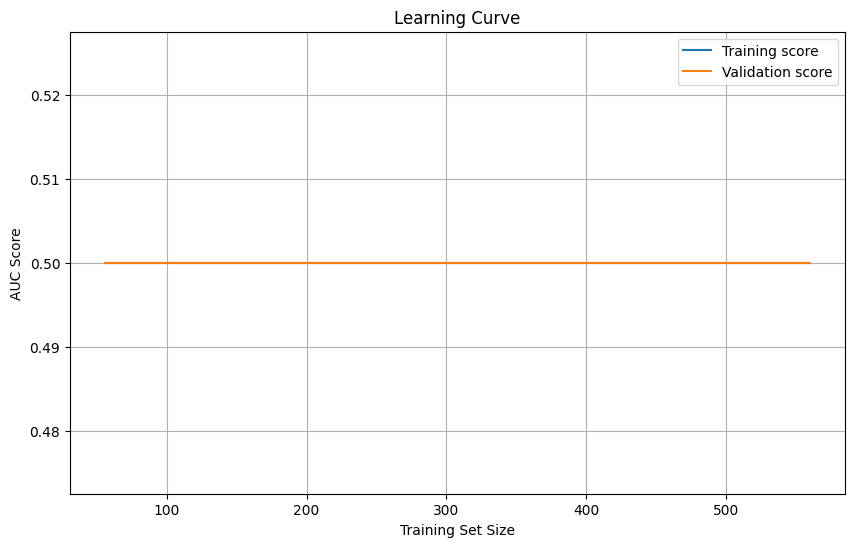


🔍 DIAGNOSIS:
❌ Low validation score - Need better features or different model
⚠️  High bias (underfitting) - Need more complex model or better features

Learning curve for LinearSVC


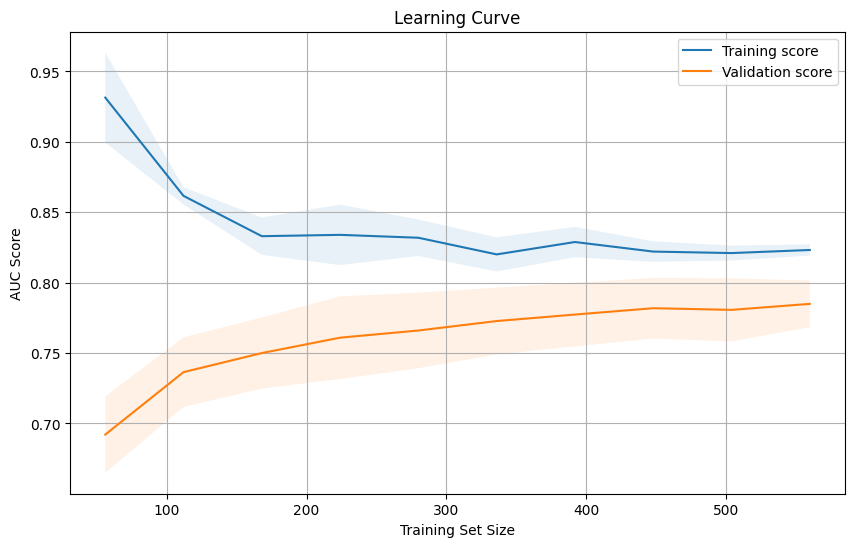


🔍 DIAGNOSIS:
✅ Good bias-variance tradeoff - Ready for tuning

Learning curve for SVC


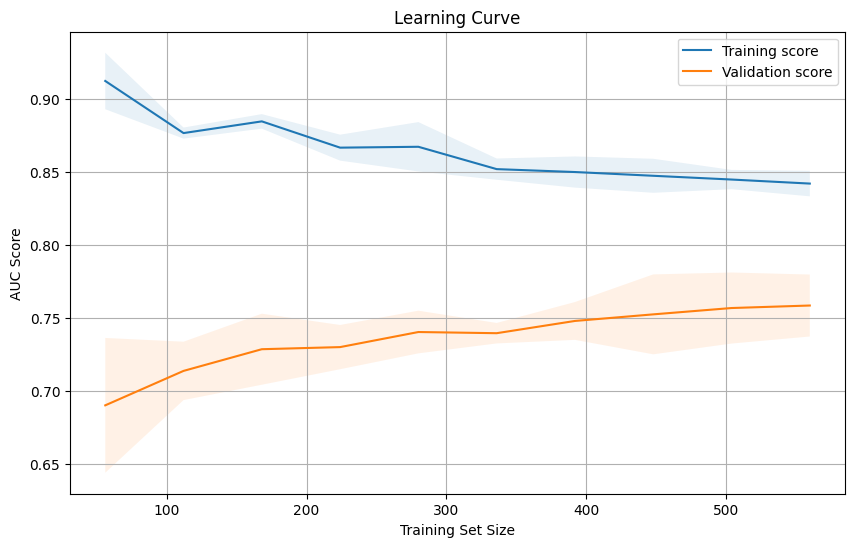


🔍 DIAGNOSIS:
✅ Good bias-variance tradeoff - Ready for tuning

Learning curve for RandomForestClassifier


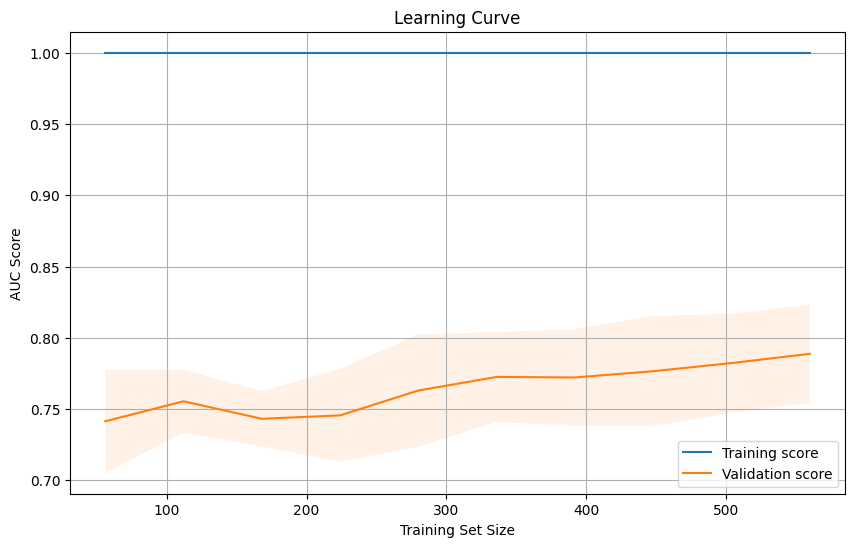


🔍 DIAGNOSIS:
⚠️  High variance (overfitting) - Need regularization or more data


In [115]:
# Run for your best model
for model in [base_dummy ,base_svc, base_svc_rbf, base_rf]:
    print(f"\nLearning curve for {model.__class__.__name__}")
    plot_learning_curve(model, engineered_train_df, y_train)


In [86]:
pd.DataFrame(base_rf.feature_importances_, index=engineered_train_df.columns, columns=["importance"]).sort_values(by="importance", ascending=False)

,importance
monthly_burden,0.156934
pct_x_amount,0.152426
checking_account_status,0.122144
duration_squared,0.116522
present_employment_since,0.063100
age_group,0.053683
credit_history,0.049416
savings_map,0.038616
other_installment_plans,0.031304
sex_map_male,0.024253


In [81]:
engineered_train_df[[ "duration_squared", "monthly_burden", "pct_x_amount"]].corr()

,duration_squared,monthly_burden,pct_x_amount
duration_squared,1.000000,-0.073044,0.625180
monthly_burden,-0.073044,1.000000,0.219698
pct_x_amount,0.625180,0.219698,1.000000


In [ ]:
cols_to_drop

['other_debtors_guarantors',
 'job',
 'telephone',
 'foreign_worker',
 'present_residence_since',
 'existing_credits_count',
 'people_liable_for_maintenance']

In [ ]:
# Categorize your variables first
ordinal_vars = [
    'checking_account',      # Clear risk order
    'credit_history',        # VERY clear risk order
    'savings_account',       # Amount ranges
    'employment',            # Duration ranges
    'other_installment_plans', # None < Bank < Stores
    'job'                    # Skill level order
]

nominal_vars = [
    'purpose',              # No natural order
    'personal_status_sex',  # Categorical combinations
    'other_debtors',        # Types of support
    'property',             # Different asset types
    'housing'               # Different situations
]

binary_vars = [
    'telephone',            # Yes/No
    'foreign_worker'        # Yes/No
]

# Apply WoE to ordinal
for var in ordinal_vars:
    woe_map, woe_table = calculate_woe(df, var, 'target')
    df[f'{var}_woe'] = df[var].map(woe_map)
    
    # Calculate IV to check predictive power
    iv = calculate_iv(woe_table)
    print(f"{var} IV: {iv:.4f}")

# Apply One-Hot to nominal
for var in nominal_vars:
    df_temp = pd.get_dummies(df[var], prefix=var, drop_first=True)
    df = pd.concat([df, df_temp], axis=1)

# Binary variables stay as 0/1
# (already encoded in dataset)


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Automatically select categorical columns
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

encoder = OneHotEncoder(
    categories="auto",
    drop="first",  # to return k-1, use drop=false to return k dummies
    sparse_output=False,
    handle_unknown="error",  # helps deal with rare labels
)


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ])

preprocessor.set_output(transform="pandas")

preprocessor.fit(train_df)

### Engineering pipeline

### Testing

<hr>